In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.serialization
from pathlib import Path

from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, global_mean_pool
from torch_geometric.loader import DataLoader
import analysis_utils

# Allow loading HeteroData under PyTorch 2.6+
torch.serialization.add_safe_globals([HeteroData])

############################################################
# 1. LOAD GRAPHS
############################################################

def load_graphs(graph_dir):
    graph_dir = Path(graph_dir)
    graphs = []
    for f in sorted(graph_dir.glob("graph_*.pt")):
        g = torch.load(f, weights_only=False)
        graphs.append(g)
    return graphs

class SpeechHeteroGNN(nn.Module):
    """
    ORIGINAL VERSION (before reduction):
    - Speech node feature = 768 embedding + 3 raw features
    - Edge aggregated features = 3 (mean_topic_score, mean_lag, mean_decay)
    - Total = 774 dims → feed into speech_lin
    """

    def __init__(self, global_idx, hidden_dim=64, num_heads=2):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Number of items for embedding lookup
        num_authors = len(global_idx["author2idx"]) + 1
        num_topics  = len(global_idx["topic2idx"]) + 1
        num_days    = len(global_idx["date2idx"]) + 1

        # Embeddings for ID-based nodes
        self.emb = nn.ModuleDict({
            "author": nn.Embedding(num_authors, hidden_dim),
            "topic":  nn.Embedding(num_topics, hidden_dim),
            "day":    nn.Embedding(num_days, hidden_dim),
        })

        # ORIGINAL DIMENSION: 768 + 3 raw features + 3 aggregated = 774
        self.speech_lin = nn.Linear(772, hidden_dim)

        # HGTConv (original)
        self.hgt = HGTConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            metadata=(
                ["author", "speech", "topic", "day"],
                [
                    ("author", "gives", "speech"),
                    ("speech", "rev_gives", "author"),
                    ("speech", "mentions", "topic"),
                    ("topic", "rev_mentions", "speech"),
                    ("day", "references", "speech"),
                    ("speech", "rev_references", "day"),
                    ("speech", "follows", "speech"),
                    ("speech", "rev_follows", "speech"),
                ]
            ),
            heads=num_heads,
        )


    ############################################################
    # ORIGINAL 3-DIM AGG FEATURES
    ############################################################
    def compute_edge_features(self, data, device):
        """
        Returns [num_speech, 3]:
          [mean_topic_score, mean_lag, mean_decay]
        """

        Ns = data["speech"].x.size(0)
        extras = torch.zeros(Ns, 2, device=device)
        count  = torch.zeros(Ns, 2, device=device)

        # 1) Topic score
        if ("speech","mentions","topic") in data.edge_types:
            store = data["speech","mentions","topic"]
            if store.edge_attr is not None:
                src = store.edge_index[0]
                score = store.edge_attr.view(-1).to(device)
                extras[:,0].index_add_(0, src, score)
                count [:,0].index_add_(0, src, torch.ones_like(score))

        # 2) lag + decay
        if ("day","references","speech") in data.edge_types:
            store = data["day","references","speech"]
            if store.edge_attr is not None:
                dst    = store.edge_index[1]
                lagdec = store.edge_attr.to(device)   # [E,2]
                extras[:,1:].index_add_(0, dst, lagdec)
                count [:,1:].index_add_(0, dst, torch.ones_like(lagdec))

        count = torch.clamp(count, min=1)
        return extras / count


    ############################################################
    # ORIGINAL FORWARD
    ############################################################
    def forward(self, data: HeteroData):
        device = data["speech"].x.device
        x_dict = {}

        # Embedding lookup for author/topic/day
        for ntype in ["author","topic","day"]:
            idx = data[ntype].x.long().view(-1)
            x_dict[ntype] = self.emb[ntype](idx)

        # Speech node features (NO REDUCTION)
        base_feats = data["speech"].x.float()   # shape [N, 771]
        edge_feats = self.compute_edge_features(data, device)

        speech_full = torch.cat([base_feats, edge_feats], dim=-1)  # [N,774]
        x_dict["speech"] = self.speech_lin(speech_full)

        # HGT message passing
        x_dict = self.hgt(x_dict, data.edge_index_dict)
        return x_dict


############################################################
# 3. TOP MODEL: Predict from day-node
############################################################

class FedSpeechModel(nn.Module):
    def __init__(self, global_idx, hidden_dim=64):
        super().__init__()
        self.gnn = SpeechHeteroGNN(global_idx, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, g: HeteroData):
        x = self.gnn(g)
        day_emb = x["day"]          # [1, hidden_dim]
        return self.fc(day_emb).squeeze()   # scalar prediction



############################################################
# 4. TRAINING AND EVALUATION
############################################################

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    n = 0

    for g in loader:
        g = g.to(device)
        target = g.y.to(device).float()

        pred = model(g)
        loss = F.mse_loss(pred, target)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        n += 1

    return total_loss / n


@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    n = 0

    for g in loader:
        g = g.to(device)
        target = g.y.to(device).float()

        pred = model(g)
        loss = F.mse_loss(pred, target)

        total_loss += loss.item()
        n += 1

    return total_loss / n



############################################################
# 5. TRAIN MODEL
############################################################

def train_model(graphs, global_idx, hidden_dim=64, epochs=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Remove graphs without speech nodes
    graphs = [g for g in graphs if g["speech"].x.size(0) > 0]

    # Chronological split
    n = len(graphs)
    n_train = int(n * 0.8)
    train_graphs = graphs[:n_train]
    val_graphs   = graphs[n_train:]

    train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_graphs, batch_size=1, shuffle=False)

    model = FedSpeechModel(global_idx, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    print(f"Training on device: {device}")
    print(f"Graphs: {n}, Train: {len(train_graphs)}, Val: {len(val_graphs)}")

    best_val = float("inf")
    best_state = None
    patience = 20
    bad_epochs = 0

    train_loss_curve = {}
    dev_loss_curve = {}

    for epoch in range(1, epochs+1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss   = eval_epoch(model, val_loader, device)

        train_loss_curve[epoch] = train_loss
        dev_loss_curve[epoch] = val_loss

        print(f"Epoch {epoch:03d} | Train={train_loss:.4f} | Val={val_loss:.4f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = model.state_dict()
            bad_epochs = 0
        else:
            bad_epochs += 1

        if bad_epochs >= patience:
            print("Early stopping.")
            break

    model.load_state_dict(best_state)
    print("Best Val MSE:", best_val)
    return model, train_loss_curve, dev_loss_curve


# Build global_idx the same way you did before building graphs
def build_global_indices(speeches, topic_scores, rates_df):
    author_names = sorted({v["author"] for v in speeches.values()})
    author2idx = {name: i for i, name in enumerate(author_names)}

    topic_names = sorted({t for sid in topic_scores for t in topic_scores[sid].keys()})
    topic2idx = {t: i for i, t in enumerate(topic_names)}

    date_names = sorted(rates_df.index)
    date2idx = {d: i for i, d in enumerate(date_names)}

    return {
        "author2idx": author2idx,
        "topic2idx": topic2idx,
        "date2idx": date2idx,
    }

############################################################
# 6. SCRIPT ENTRYPOINT
############################################################

if __name__ == "__main__":
    graphs = load_graphs("graphs_ffr_delta")
    
    speeches = analysis_utils.load_speeches()
    topic_scores = analysis_utils.load_topic_scores_by_sid()
    rates_df = analysis_utils.load_rates()


    # You should load global_idx from your preprocessing
    # Here is a placeholder example:
    #global_idx = torch.load("global_idx.pt")  # or construct manually
    global_idx = build_global_indices(speeches, topic_scores, rates_df)

    model, train_loss, validation_loss = train_model(graphs, global_idx, hidden_dim=16, epochs=100)


Training on device: cpu
Graphs: 647, Train: 517, Val: 130


C:\Users\MainUser\AppData\Local\Temp\ipykernel_36200\2690147728.py:165: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, target)
C:\Users\MainUser\AppData\Local\Temp\ipykernel_36200\2690147728.py:189: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, target)


Epoch 001 | Train=0.0368 | Val=0.0258
Epoch 002 | Train=0.0246 | Val=0.0175
Epoch 003 | Train=0.0212 | Val=0.0181
Epoch 004 | Train=0.0174 | Val=0.0132
Epoch 005 | Train=0.0153 | Val=0.0108
Epoch 006 | Train=0.0128 | Val=0.0097
Epoch 007 | Train=0.0113 | Val=0.0112
Epoch 008 | Train=0.0098 | Val=0.0122
Epoch 009 | Train=0.0086 | Val=0.0056
Epoch 010 | Train=0.0076 | Val=0.0054
Epoch 011 | Train=0.0066 | Val=0.0086
Epoch 012 | Train=0.0059 | Val=0.0041
Epoch 013 | Train=0.0055 | Val=0.0055
Epoch 014 | Train=0.0051 | Val=0.0040
Epoch 015 | Train=0.0046 | Val=0.0032
Epoch 016 | Train=0.0042 | Val=0.0033
Epoch 017 | Train=0.0039 | Val=0.0038
Epoch 018 | Train=0.0037 | Val=0.0029
Epoch 019 | Train=0.0035 | Val=0.0031
Epoch 020 | Train=0.0033 | Val=0.0027
Epoch 021 | Train=0.0033 | Val=0.0028
Epoch 022 | Train=0.0031 | Val=0.0028
Epoch 023 | Train=0.0029 | Val=0.0026
Epoch 024 | Train=0.0029 | Val=0.0038
Epoch 025 | Train=0.0029 | Val=0.0028
Epoch 026 | Train=0.0027 | Val=0.0025
Epoch 027 | 

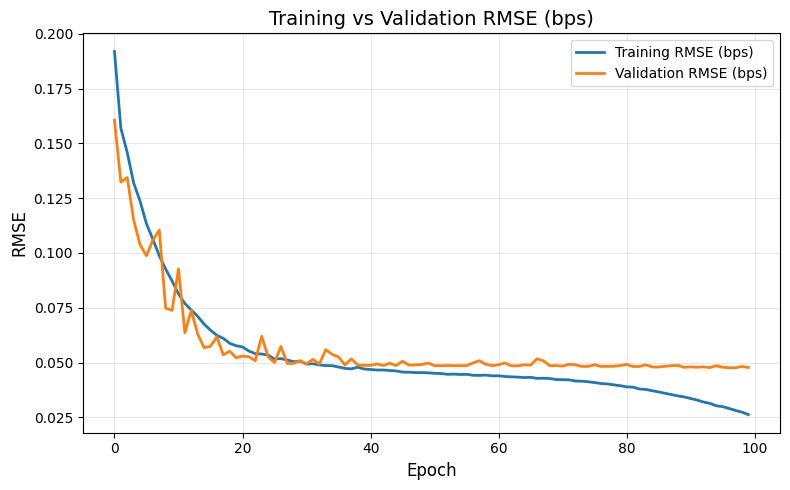

In [30]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def plot_rmse(train_loss, validation_loss):
    # Convert MSE → RMSE
    train_rmse = np.sqrt(train_loss)
    val_rmse   = np.sqrt(validation_loss)

    plt.figure(figsize=(8, 5))

    plt.plot(train_rmse, label="Training RMSE (bps)", linewidth=2)
    plt.plot(val_rmse, label="Validation RMSE (bps)", linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.title("Training vs Validation RMSE (bps)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.show()
    plt.savefig("training_validation_rmse.png", dpi=300, bbox_inches='tight')


plot_rmse(list(train_loss.values()), list(validation_loss.values()))
